In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from internal.dataparsers.matrix_city_dataparser import MatrixCity
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
torch.set_grad_enabled(False)
torch.set_printoptions(precision=16)

In [4]:
from internal.utils.partitioning_utils import SceneConfig, Partitioning

In [5]:
dataset_path = os.path.expanduser("~/data-extra/MatrixCity/small_city-self_render/street_without_water/")

find `transforms.json`

In [6]:
train_transforms_json_list = []
test_transforms_json_list = []
for dir in os.scandir(dataset_path):
    if dir.is_dir() is False:
        continue

    target_list = train_transforms_json_list
    if dir.name.endswith("_test") is True:
        target_list = test_transforms_json_list

    if not os.path.exists(os.path.join(dir.path, "transforms.json")):
        continue
    target_list.append(os.path.join(dir.name, "transforms.json"))

train_transforms_json_list, test_transforms_json_list

(['small_city_road_vertical_dense/transforms.json',
  'small_city_road_horizon_dense/transforms.json',
  'small_city_road_down_dense/transforms.json',
  'small_city_road_outside_dense/transforms.json'],
 ['small_city_road_outside_test/transforms.json',
  'small_city_road_down_test/transforms.json',
  'small_city_road_vertical_test/transforms.json',
  'small_city_road_horizon_test/transforms.json'])

# 1. Setup dataparser

In [7]:
dataparser = MatrixCity(
    train=train_transforms_json_list,
    test=test_transforms_json_list,
    depth_read_step=32,
    max_points=512_000,
    point_cloud_generation_device="cuda",
).instantiate(
    path=dataset_path,
    output_path=os.path.abspath(""),
    global_rank=0,
)
dataparser

In [8]:
dataparser_outputs = dataparser.get_outputs()

{
    "train": [
        "small_city_road_down_dense/transforms.json",
        "small_city_road_horizon_dense/transforms.json",
        "small_city_road_outside_dense/transforms.json",
        "small_city_road_vertical_dense/transforms.json"
    ],
    "scale": 0.01,
    "depth_scale": 0.01,
    "max_depth": 65000,
    "depth_read_step": 32,
    "max_points": 512000
}


  0%|          | 0/4228 [00:00<?, ?it/s]

Point cloud saved to '/home/zhensheng/data-extra/MatrixCity/small_city-self_render/street_without_water/501ae28df87a89501e5a05a3bfb561d9e7796f7b.ply'


In [9]:
train_image_set = dataparser_outputs.train_set
test_image_set = dataparser_outputs.test_set
point_cloud = dataparser_outputs.point_cloud
len(train_image_set), len(test_image_set), len(point_cloud.xyz)

(135290, 3255, 513903)

plot scene and cameras

In [10]:
train_camera_centers = train_image_set.cameras.camera_center.cpu().numpy()
test_camera_centers = test_image_set.cameras.camera_center.cpu().numpy()

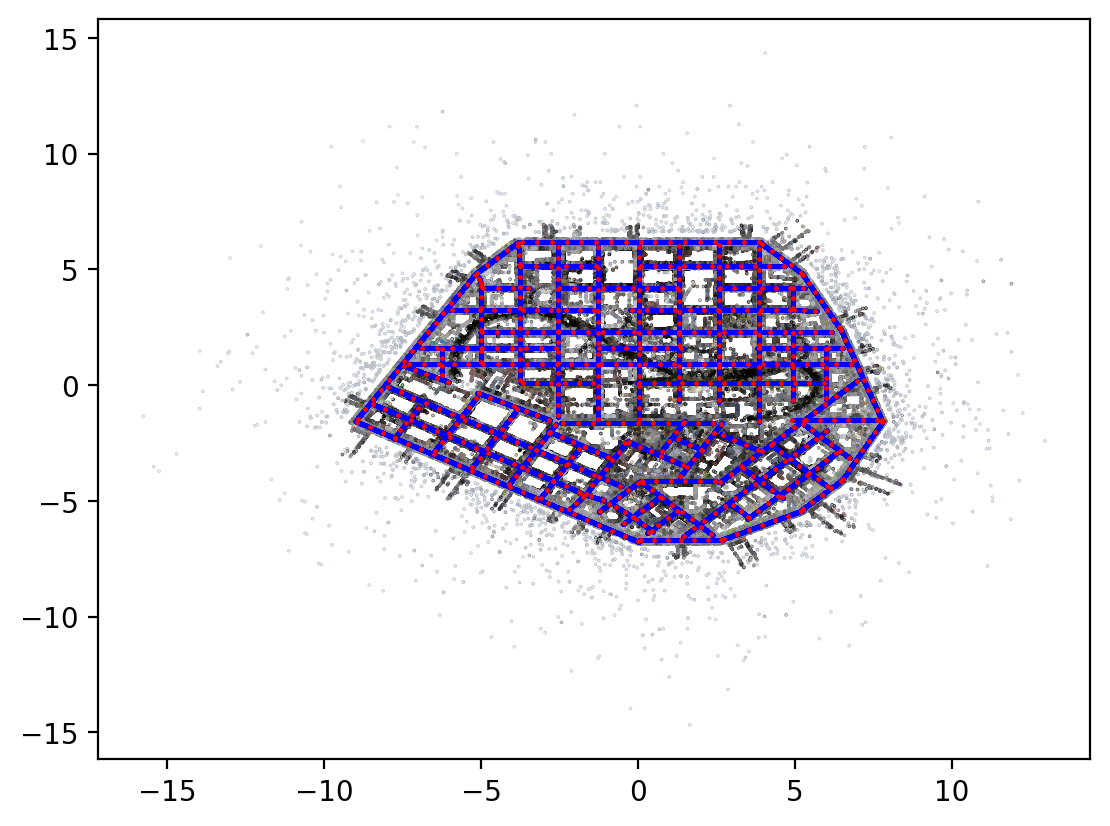

In [11]:
fig, ax = plt.subplots()
ax.scatter(point_cloud.xyz[:, 0], point_cloud.xyz[:, 1], c=point_cloud.rgb / 255., s=0.1)
ax.scatter(train_camera_centers[:, 0], train_camera_centers[:, 1], s=0.2, c="blue")
ax.scatter(test_camera_centers[:, 0], test_camera_centers[:, 1], s=0.2, c="red")
plt.show()

# 2. Build partitions

choose scene origin and partition size

In [12]:
scene_config = SceneConfig(
    origin=torch.tensor([0., 0.]),  # scene origin does not locate in the partition center, it is the corner
    partition_size=1.8,
)

calculate bounding box and number of partitions

In [13]:
basic_bounding_box = Partitioning.get_bounding_box_by_camera_centers(
    train_image_set.cameras.camera_center[..., :2],
)
basic_bounding_box

MinMaxBoundingBox(min=tensor([-9.0101261138916016, -6.7752251625061035]), max=tensor([7.7927474975585938, 6.1997227668762207]))

In [14]:
scene_bounding_box = Partitioning.align_bounding_box(
    basic_bounding_box,
    scene_config.origin,
    scene_config.partition_size,
)
scene_bounding_box

SceneBoundingBox(bounding_box=MinMaxBoundingBox(min=tensor([-10.7999992370605469,  -7.1999998092651367]), max=tensor([9.0000000000000000, 7.1999998092651367])), n_partitions=tensor([11,  8]), origin_partition_offset=tensor([-6, -4]))

plot bounding box

In [15]:
def set_plot_ax_limit(ax):
    plot_enlarge = 0.25
    ax.set_xlim([
        scene_bounding_box.bounding_box.min[0] - plot_enlarge * scene_config.partition_size,
        scene_bounding_box.bounding_box.max[0] + plot_enlarge * scene_config.partition_size,
    ])
    ax.set_ylim([
        scene_bounding_box.bounding_box.min[1] - plot_enlarge * scene_config.partition_size,
        scene_bounding_box.bounding_box.max[1] + plot_enlarge * scene_config.partition_size,
    ])

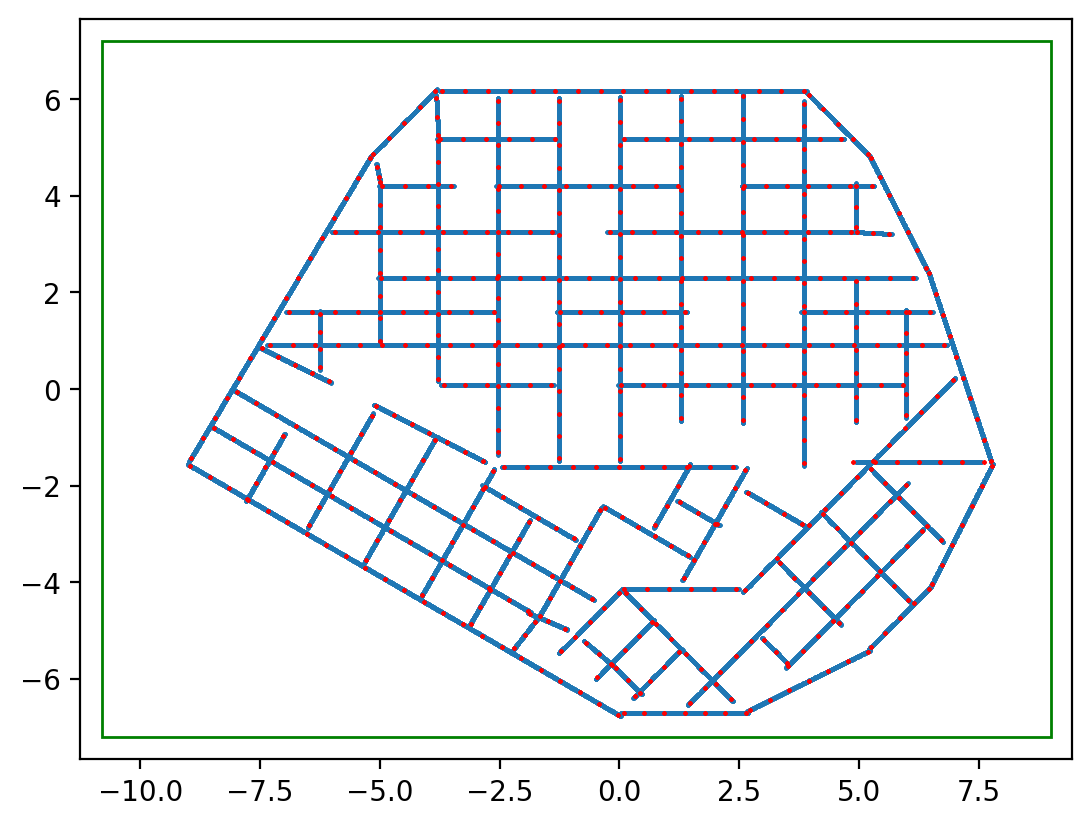

In [16]:
plt.close()
fig, ax = plt.subplots()
ax.scatter(train_camera_centers[:, 0], train_camera_centers[:, 1], s=0.2)
ax.scatter(test_camera_centers[:, 0], test_camera_centers[:, 1], s=0.2, c="red")
ax.add_artist(mpatches.Rectangle(
    (scene_bounding_box.bounding_box.min[0], scene_bounding_box.bounding_box.min[1]),
    scene_bounding_box.bounding_box.max[0] - scene_bounding_box.bounding_box.min[0],
    scene_bounding_box.bounding_box.max[1] - scene_bounding_box.bounding_box.min[1],
    fill=False,
    color="green",
))
set_plot_ax_limit(ax)
plt.show(fig)

build partition coordinates

In [17]:
partition_coordinates = Partitioning.build_partition_coordinates(
    scene_bounding_box,
    scene_config.partition_size,
)
partition_coordinates

PartitionCoordinates(id=tensor([[-6, -4],
        [-5, -4],
        [-4, -4],
        [-3, -4],
        [-2, -4],
        [-1, -4],
        [ 0, -4],
        [ 1, -4],
        [ 2, -4],
        [ 3, -4],
        [ 4, -4],
        [-6, -3],
        [-5, -3],
        [-4, -3],
        [-3, -3],
        [-2, -3],
        [-1, -3],
        [ 0, -3],
        [ 1, -3],
        [ 2, -3],
        [ 3, -3],
        [ 4, -3],
        [-6, -2],
        [-5, -2],
        [-4, -2],
        [-3, -2],
        [-2, -2],
        [-1, -2],
        [ 0, -2],
        [ 1, -2],
        [ 2, -2],
        [ 3, -2],
        [ 4, -2],
        [-6, -1],
        [-5, -1],
        [-4, -1],
        [-3, -1],
        [-2, -1],
        [-1, -1],
        [ 0, -1],
        [ 1, -1],
        [ 2, -1],
        [ 3, -1],
        [ 4, -1],
        [-6,  0],
        [-5,  0],
        [-4,  0],
        [-3,  0],
        [-2,  0],
        [-1,  0],
        [ 0,  0],
        [ 1,  0],
        [ 2,  0],
        [ 3,  0],
    

plot partitions

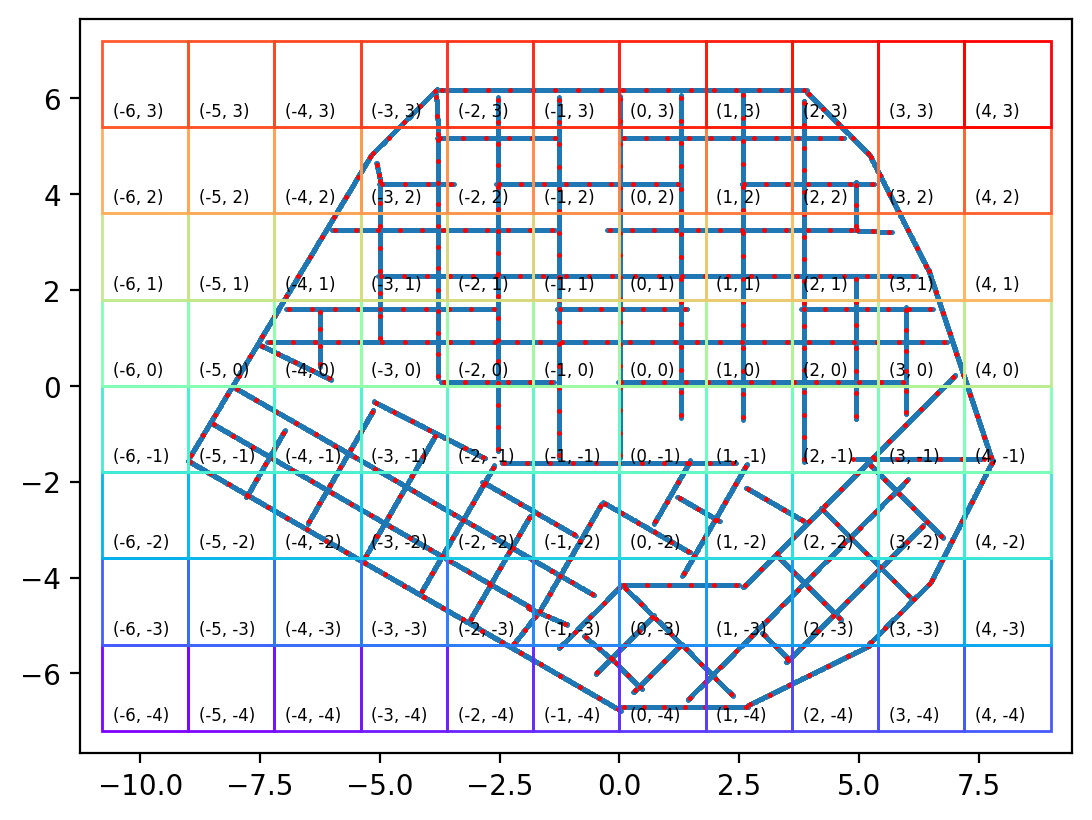

In [18]:
plt.close()
# import random
from matplotlib.pyplot import cm
import numpy as np

colors = list(iter(cm.rainbow(np.linspace(0, 1, len(partition_coordinates)))))
# random.shuffle(colors)
fig, ax = plt.subplots()
ax.scatter(train_camera_centers[:, 0], train_camera_centers[:, 1], s=0.2)
ax.scatter(test_camera_centers[:, 0], test_camera_centers[:, 1], s=0.2, c="red")
set_plot_ax_limit(ax)
ax.set_aspect('equal', adjustable='box')

color_iter = iter(colors)
for partition_id, partition_xy in partition_coordinates:
    ax.add_artist(mpatches.Rectangle(
        (partition_xy[0], partition_xy[1]),
        scene_config.partition_size,
        scene_config.partition_size,
        fill=False,
        color=next(color_iter),
    ))
    ax.annotate(
        "({}, {})".format(partition_id[0], partition_id[1]),
        xy=(
            partition_xy[0] + 0.125 * scene_config.partition_size,
            partition_xy[1] + 0.125 * scene_config.partition_size,
        ),
        fontsize=6,
    )

plt.show(fig)

# 3. Assign images to partitions

## 3.1. Location based assignment

In [19]:
scene_config.location_based_enlarge = 0.1

In [20]:
is_camera_in_partition = Partitioning.camera_center_based_partition_assignment(
    partition_coordinates,
    train_image_set.cameras.camera_center[..., :2],
    scene_config.partition_size,
    enlarge=scene_config.location_based_enlarge,
)
is_camera_in_partition.sum(dim=-1)

tensor([   0,    0,    0,    0,  730, 2530, 3620, 3060, 1610,  110,    0,    0,
           0,  430, 2170, 4105, 3870, 3165, 2715, 3830, 2320,    0,   45, 1515,
        3170, 4120, 4035, 2060, 2700, 2690, 3775, 3230,  810,  260, 3430, 3020,
        2685, 3010, 3180, 3600, 2135, 3535, 3640, 1425,    0, 1730, 3785, 3755,
        4745, 4415, 5050, 3240, 5215, 4195,  465,    0,   85, 1655, 4050, 4320,
        3775, 4320, 3240, 3840, 1930,    0,    0,    0,  780, 3630, 3725, 3670,
        3870, 2785, 4040,  845,    0,    0,    0,    0, 1305, 1485, 1900, 1920,
        1535, 1265,    0,    0])

## 3.2. Visibility based assignment

the visibility is calculated from 3D points of every camera

In [21]:
from internal.utils.depth_map_utils import depth_map_to_colored_points_with_down_sample, read_depth, enable_exr
from internal.utils.image_utils import read_image, rgba2rgb

enable_exr()

In [22]:
# some parameters may need to be changed
scene_config.visibility_based_distance = 0.6  # enlarge bounding box by `partition_size * max_visible_distance`, only those cameras inside this enlarged box will be used for visibility based assignment
scene_config.visibility_threshold = 0.1

visibility_calculating_on_device = torch.device("cuda")
depth_map_down_sample_factor = 4

In [23]:
final_depth_scale = dataparser.params.scale * dataparser.params.depth_scale
c2ws = torch.linalg.inv(train_image_set.cameras.world_to_camera.transpose(1, 2)).to(
    device=visibility_calculating_on_device)

In [24]:
torch.inverse(torch.ones((1, 1), device=c2ws.device))  # https://github.com/pytorch/pytorch/issues/90613#issuecomment-1817307008


def generate_camera_3d_points(camera_idx: int, with_colors: bool = False):
    depth = torch.from_numpy(read_depth(train_image_set.extra_data[camera_idx])).to(
        dtype=c2ws.dtype,
        device=c2ws.device,
    ) * final_depth_scale
    rgb = None
    if with_colors is True:
        rgb = rgba2rgb(read_image(train_image_set.image_paths[camera_idx]))
    generated_points = depth_map_to_colored_points_with_down_sample(
        depth_map=depth,
        rgb=rgb,
        fx=train_image_set.cameras.fx[camera_idx],
        fy=train_image_set.cameras.fy[camera_idx],
        cx=train_image_set.cameras.cx[camera_idx],
        cy=train_image_set.cameras.cy[camera_idx],
        c2w=c2ws[camera_idx],
        down_sample_factor=depth_map_down_sample_factor,
        valid_pixel_mask=depth < dataparser.params.max_depth * final_depth_scale,
    )
    if with_colors is True:
        return generated_points[0], generated_points[1]
    return generated_points

validate that 3D point generation is correct

In [25]:
points_list = []
rgbs_list = []
for camera_idx in tqdm(list(range(0, min(2048, len(train_image_set)), 8))):
    points, rgbs = generate_camera_3d_points(
        camera_idx=camera_idx,
        with_colors=True
    )
    points_list.append(points.cpu())
    rgbs_list.append(rgbs)
len(points_list), len(rgbs_list)

  0%|          | 0/256 [00:00<?, ?it/s]

(256, 256)

In [26]:
from internal.utils.graphics_utils import store_ply

store_ply("test.ply", torch.concat(points_list, dim=0).numpy(), np.concatenate(rgbs_list, axis=0))
print("view '{}' to validate whether 3D points from different cameras are aligned".format(os.path.realpath("test.ply")))

view '/home/zhensheng/PycharmProjects/gaussian-splatting-pl/notebooks/test.ply' to validate whether 3D points from different cameras are aligned


confirmed that the generated 3D points are correct, then start calculating the visibilities

In [27]:
camera_visibilities = Partitioning.cameras_point_based_visibilities_calculation(
    partition_coordinates=partition_coordinates,
    size=scene_config.partition_size,
    n_cameras=len(train_image_set),
    point_getter=generate_camera_3d_points,
    device=c2ws.device,
)  # [N_partitions, N_cameras]

  0%|          | 0/135290 [00:00<?, ?it/s]

In [28]:
camera_visibilities.shape

torch.Size([88, 135290])

assign cameras to partitions based on visibilities

In [29]:
is_partitions_visible_to_cameras = Partitioning.visibility_based_partition_assignment(
    partition_coordinates=partition_coordinates,
    camera_centers=train_image_set.cameras.camera_center[..., :2],
    size=scene_config.partition_size,
    max_distance=scene_config.visibility_based_distance,
    assigned_mask=is_camera_in_partition,
    visibilities=camera_visibilities,
    visibility_threshold=scene_config.visibility_threshold,
)  # [N_partitions, N_cameras]
assert not torch.any(torch.logical_and(is_partitions_visible_to_cameras, is_camera_in_partition))
is_partitions_visible_to_cameras.sum(dim=-1), is_partitions_visible_to_cameras.shape

(tensor([   0,    0,    0,    0,    4,  183, 1052,  561,    0,   18,    0,    0,
            0,   75,   30,  270,  971,  287, 1514,  921,  120,    0,    3,   26,
           74,  278,  290,  827, 1947, 1399, 1107, 1481,    0,    2,  356,  258,
          116,  231,  233,  798, 1331,  397, 1048,    5,    0,   57,  259,  230,
          171,  477,  134,  473,  190,  998,   39,    0,    0,  571,  343,  243,
          696,  374,  913,  534,  477,    0,    0,    0,   49,  328,  456,  224,
           93,  172,  391,    7,    0,    0,    0,    0,   45,  156,  197,  110,
           89,  143,    0,    0]),
 torch.Size([88, 135290]))

In [30]:
is_camera_assigned_to_partition = torch.logical_or(is_camera_in_partition, is_partitions_visible_to_cameras)
is_camera_assigned_to_partition.sum(dim=-1)

tensor([   0,    0,    0,    0,  734, 2713, 4672, 3621, 1610,  128,    0,    0,
           0,  505, 2200, 4375, 4841, 3452, 4229, 4751, 2440,    0,   48, 1541,
        3244, 4398, 4325, 2887, 4647, 4089, 4882, 4711,  810,  262, 3786, 3278,
        2801, 3241, 3413, 4398, 3466, 3932, 4688, 1430,    0, 1787, 4044, 3985,
        4916, 4892, 5184, 3713, 5405, 5193,  504,    0,   85, 2226, 4393, 4563,
        4471, 4694, 4153, 4374, 2407,    0,    0,    0,  829, 3958, 4181, 3894,
        3963, 2957, 4431,  852,    0,    0,    0,    0, 1350, 1641, 2097, 2030,
        1624, 1408,    0,    0])

# 4. Preview

In [31]:
location_base_assignment_bounding_boxes = partition_coordinates.get_bounding_boxes(
    size=scene_config.partition_size,
    enlarge=scene_config.location_based_enlarge,
)
location_base_assignment_bounding_box_sizes = location_base_assignment_bounding_boxes.max - location_base_assignment_bounding_boxes.min

In [32]:
visibility_base_assignment_bounding_boxes = partition_coordinates.get_bounding_boxes(
    size=scene_config.partition_size,
    enlarge=scene_config.visibility_based_distance,
)
visibility_base_assignment_bounding_box_size = visibility_base_assignment_bounding_boxes.max - visibility_base_assignment_bounding_boxes.min

In [33]:
def plot_partition_assigned_cameras(partition_idx: int):
    location_based_assignment = is_camera_in_partition[partition_idx]
    visibility_based_assignment = is_partitions_visible_to_cameras[partition_idx]
    location_based_assignment.nonzero().squeeze(-1), visibility_based_assignment.nonzero().squeeze(-1)

    fig, ax = plt.subplots()
    ax.scatter(point_cloud.xyz[::4, 0], point_cloud.xyz[::4, 1], c=point_cloud.rgb[::4] / 255., s=0.1)

    # plot original partition bounding box
    ax.add_artist(mpatches.Rectangle(
        partition_coordinates.xy[partition_idx],
        scene_config.partition_size,
        scene_config.partition_size,
        fill=False,
        color="green",
    ))

    # plot location based assignment bounding box
    ax.add_artist(mpatches.Rectangle(
        location_base_assignment_bounding_boxes.min[partition_idx],
        location_base_assignment_bounding_box_sizes[partition_idx, 0].item(),
        location_base_assignment_bounding_box_sizes[partition_idx, 1].item(),
        fill=False,
        color="purple",
    ))

    # plot visibility based assignment bounding box
    ax.add_artist(mpatches.Rectangle(
        visibility_base_assignment_bounding_boxes.min[partition_idx],
        visibility_base_assignment_bounding_box_size[partition_idx, 0].item(),
        visibility_base_assignment_bounding_box_size[partition_idx, 1].item(),
        fill=False,
        color="yellow",
    ))

    # plot assigned cameras
    ax.scatter(train_camera_centers[location_based_assignment.numpy(), 0],
               train_camera_centers[location_based_assignment.numpy(), 1], s=0.2, c="blue")
    ax.scatter(train_camera_centers[visibility_based_assignment.numpy(), 0],
               train_camera_centers[visibility_based_assignment.numpy(), 1], s=0.2, c="red")

    ax.annotate(
        text="({}, {})".format(partition_coordinates.id[partition_idx, 0].item(),
                               partition_coordinates.id[partition_idx, 1].item()),
        xy=partition_coordinates.xy[partition_idx] + 0.05 * scene_config.partition_size,
        color="orange",
    )

    # lim_offset = 0.1 * scene_meta.partition_size
    # ax.set_xlim([
    #     visibility_base_assignment_bounding_boxes.min[partition_idx, 0] - lim_offset,
    #     visibility_base_assignment_bounding_boxes.max[partition_idx, 0] - lim_offset,
    # ])
    # ax.set_ylim([
    #     visibility_base_assignment_bounding_boxes.min[partition_idx, 1] + lim_offset,
    #     visibility_base_assignment_bounding_boxes.max[partition_idx, 1] + lim_offset,
    # ])
    set_plot_ax_limit(ax)

    plt.show()

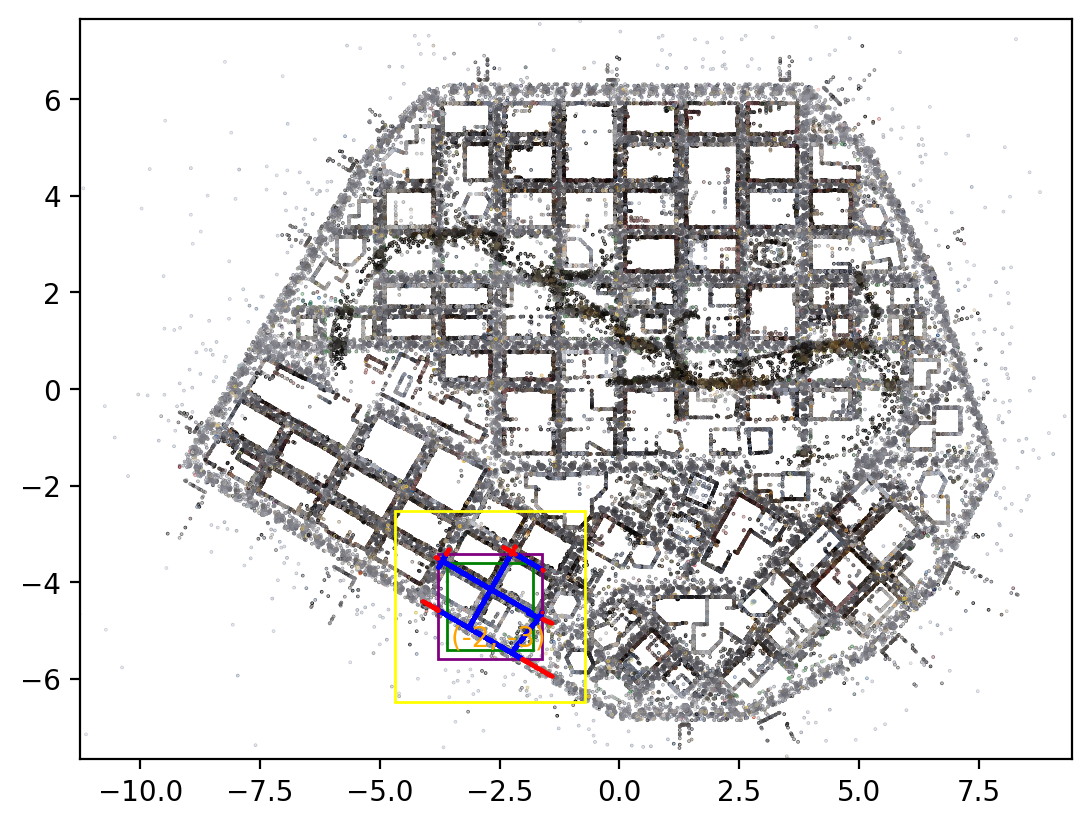

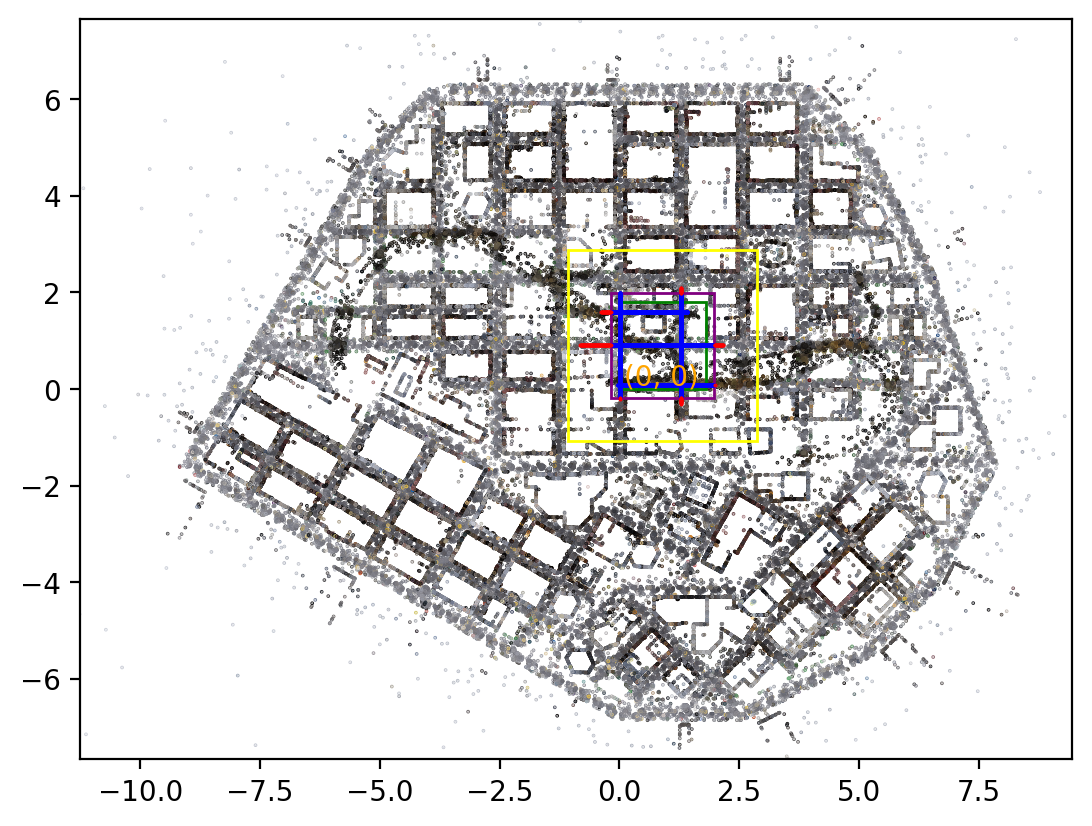

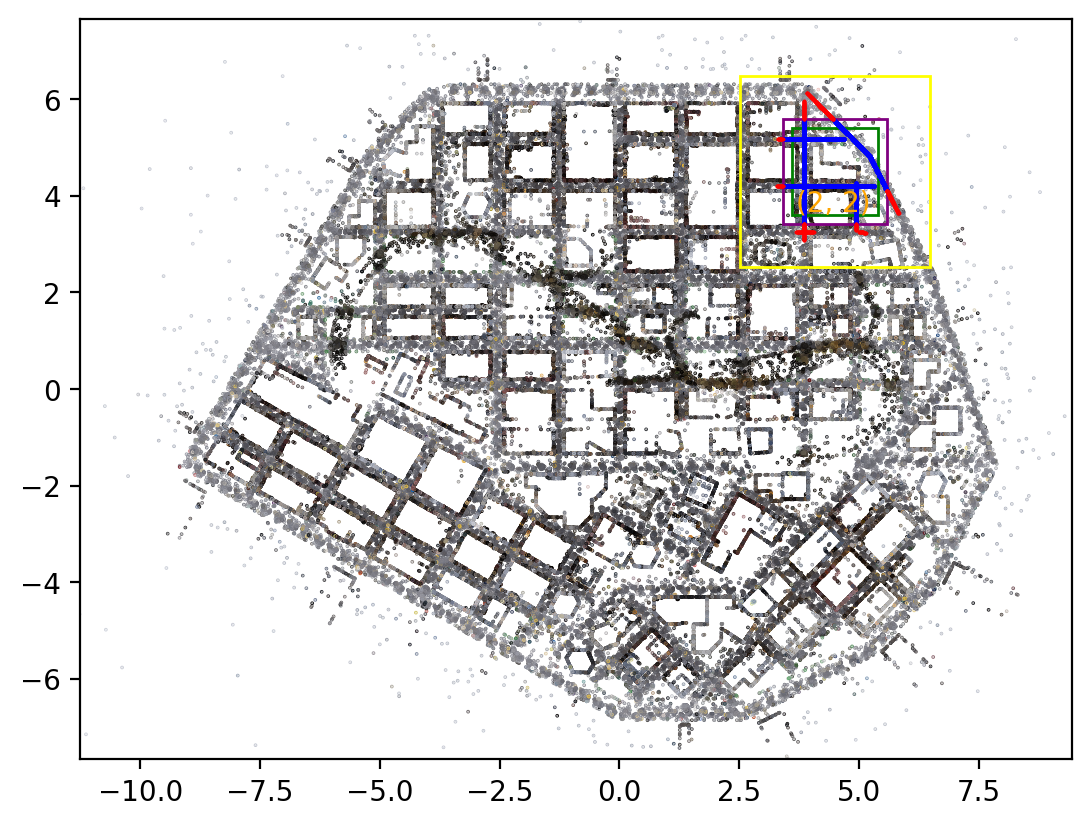

In [34]:
# plot_partitions = range(len(partition_coordinates))  # plot all partitions

plot_partitions = []
# only plot specific partitions
for idx, i in enumerate(partition_coordinates):
    if i[0].tolist() in [
        [-2, -3],
        [0, 0],
        [2, 2],
    ]:
        plot_partitions.append(idx)

for idx in plot_partitions:
    plot_partition_assigned_cameras(idx)

# 5. Saving

In [35]:
output_path = os.path.join(dataset_path, "partitions-size_{}-enlarge_{}-visibility_{}_{}".format(
    scene_config.partition_size,
    scene_config.location_based_enlarge,
    scene_config.visibility_based_distance,
    scene_config.visibility_threshold,
))
os.makedirs(output_path, exist_ok=True)

In [36]:
Partitioning.save_partitions(
    output_path,
    scene_config=scene_config,
    scene_bounding_box=scene_bounding_box,
    partition_coordinates=partition_coordinates,
    visibilities=camera_visibilities,
    location_based_assignments=is_camera_in_partition,
    visibility_based_assignments=is_partitions_visible_to_cameras,
)

'/home/zhensheng/data-extra/MatrixCity/small_city-self_render/street_without_water/partitions-size_1.8-enlarge_0.1-visibility_0.6_0.1/partitions.pt'

In [37]:
# load transforms
import json

train_frames = []
for i in dataparser.params.train:
    with open(os.path.join(dataset_path, i), "r") as f:
        transforms = json.load(f)
        for frame in transforms["frames"]:
            frame["path"] = os.path.join("..", os.path.dirname(i))
            frame["camera_angle_x"] = transforms["camera_angle_x"]
            train_frames.append(frame)
len(train_frames)

135290

In [38]:
# NOTE: test set are contained in the train set

max_test_frames = 64

for partition_idx in tqdm(list(range(is_camera_assigned_to_partition.shape[0]))):
    partition_camera_indices = is_camera_assigned_to_partition[partition_idx].nonzero().squeeze(-1).numpy().tolist()
    if len(partition_camera_indices) == 0:
        continue

    frames = []
    for camera_idx in partition_camera_indices:
        frames.append(train_frames[camera_idx])

    partition_info = {
        "idx": partition_idx,
        "id": partition_coordinates.id[partition_idx].numpy().tolist(),
        "xy": partition_coordinates.xy[partition_idx].numpy().tolist(),
        "size": scene_config.partition_size,
    }

    partition_train_transforms = {
        "partition": partition_info,
        "camera_angle_x": frames[0]["camera_angle_x"],
        "frames": frames,
    }
    partition_test_transforms = {
        "partition": partition_info,
        "camera_angle_x": frames[0]["camera_angle_x"],
        "frames": frames[::max(len(frames) // max_test_frames, 8)],
    }

    with open(os.path.join(
            output_path,
            "partition-{}.json".format(Partitioning.partition_id_to_str(partition_coordinates.id[partition_idx])),
    ), "w") as f:
        json.dump(partition_train_transforms, f, indent=4, ensure_ascii=False)
    with open(os.path.join(
            output_path,
            "partition-{}-test.json".format(Partitioning.partition_id_to_str(partition_coordinates.id[partition_idx])),
    ), "w") as f:
        json.dump(partition_test_transforms, f, indent=4, ensure_ascii=False)

  0%|          | 0/88 [00:00<?, ?it/s]